In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import subprocess
import multiprocessing
from multiprocessing import Pool, freeze_support
from functools import partial
from itertools import product
from kneed import KneeLocator
from adjustText import adjust_text
import statsmodels
import sys
import warnings
from sklearn.preprocessing import scale
from IPython.display import Image

## Set input file names, conditions, and output directories
anndata_file = '../../data_save/temp_int.h5ad'
interactions_file='data/interactions.txt'

# this should be location of tutorial files/scripts
tutorial_dir='./'

# set output directory
#output_dir='/home/ubuntu/cart.contact.tracing'

### MIN_LINKS cGASKO-PD1 = 5, links_min_ligand_absLog2FC=0.0,
### MIN_LINKS MCAK-iso = 1, links_min_ligand_absLog2FC=0.0,
### MIN_LINKS cGASKO-iso = 1, links_min_ligand_absLog2FC=0.0,
### MIN_LINKS MCAK_PD1 = links_min_numSigI1=5, links_min_ligand_absLog2FC=0.15,
                          
                          


output_dir='../cGASKO-PD1/'

# tmp_output_dir for unimportant/intermediate output
tmp_output_dir=f'{output_dir}/tmp/NOBACKUP'
!mkdir -p {tmp_output_dir}
sys.path.append(f'{tutorial_dir}/python')

In [2]:
#target_stats

In [3]:
interactions = pd.read_csv(interactions_file, sep='\t')
interactions

#target_stats = pd.read_csv(f'{output_dir}/target_stats.csv')
target_stats = pd.read_csv('../../../lkb1_mice_backups/cGASKO-PD1/cGASKO-PD1/target_stats.csv')


#target_stats = target_stats[target_stats['cell type'].isin(cell_types_of_interest)]



In [4]:
target_stats

,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,0,Endothelial,Bdnf,0.013441,0.325933,-0.055055,0.782573,142.752370,0.006076,0.0,False,True,3.549973,0.002300
1,1,Endothelial,Cav1,0.142473,-0.251042,-0.052878,-0.602757,228.682800,0.009733,3.0,True,False,NaN,NaN
2,2,Endothelial,Ccbe1,0.026882,0.373745,-0.075447,0.897371,185.955930,0.007915,1.0,True,False,NaN,NaN
3,3,Endothelial,Cd34,0.370968,-0.326943,-0.109909,-0.784998,213.478450,0.009086,1.0,True,False,-1.829768,0.001476
4,4,Endothelial,Col13a1,0.295699,-0.282335,-0.068469,-0.677893,209.744740,0.008927,4.0,True,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,Tcells,Icos,0.290393,0.400098,-0.065107,0.524096,69.574980,0.002961,1.0,True,False,NaN,NaN
246,246,Tcells,Kit,0.054585,-0.715080,0.000341,-0.936698,92.468660,0.003936,1.0,True,False,NaN,NaN
247,247,Tcells,Ncam1,0.013100,-0.376598,-0.067193,-0.493314,80.096146,0.003409,0.0,False,True,-0.309866,0.044335
248,248,Tcells,Nrg1,0.019651,-0.153271,0.156484,-0.200773,79.850190,0.003399,0.0,False,True,-0.418306,0.017839


In [8]:
cellType_colormap = {
    'B_cells':'#F9D318', 'Endothelial': '#6B0C0C', 'Fibroblasts':'#216C04',
                     'Malignant': '#51119A', 'Myeloid': '#F47D08','T_cells':'#A4D10A','Other':'#51119A'
}


In [9]:

import contactTracing_library as ct


In [10]:
target_stats
target_stats[['ligand', 'receptor']].value_counts()

ligand  receptor
True    False       151
False   True         95
True    True          4
dtype: int64

In [11]:
assignment_df = []
interactions_df = pd.read_csv("../../../lkb1_mice_backups/cGASKO-PD1/cGASKO-PD1/ranked_interactions.txt", sep = "\t")

target_log2FC_dict = dict(zip(target_stats[target_stats["ligand"]]["target"], target_stats[target_stats["ligand"]]["log2FC"]))

interactions_df= interactions_df[interactions_df["ligand"].isin(target_log2FC_dict.keys())]

for i,x in interactions_df.iterrows():
    assignment_df.append([x['ligand'], x['cell_type_ligand'], target_log2FC_dict[x['ligand']]
                         
                         ])
    assignment_df.append([x['receptor'], x['cell_type_receptor'], target_log2FC_dict[x['ligand']]])
    
    
df = pd.DataFrame(assignment_df, columns = ['target', 'cell type', 'logFC_column'])
df['logFC_column'] = df['logFC_column'].apply(lambda x: -1 if x < 0 else 1)


In [12]:
df_grouped = df.groupby(['target', 'cell type'], as_index=False)['logFC_column'].mean()
df_grouped



missing_pairs = target_stats.merge(df_grouped, on=['target', 'cell type'], how='left', indicator=True)
missing_pairs = missing_pairs[missing_pairs['_merge'] == 'left_only']
missing_pairs = missing_pairs[['target', 'cell type']]
missing_pairs

,target,cell type


In [13]:
merged_df = pd.merge(target_stats, df_grouped, on=['target', 'cell type'], how='left')
merged_df

,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,logFC_column
0,0,Endothelial,Bdnf,0.013441,0.325933,-0.055055,0.782573,142.752370,0.006076,0.0,False,True,3.549973,0.002300,1.000000
1,1,Endothelial,Cav1,0.142473,-0.251042,-0.052878,-0.602757,228.682800,0.009733,3.0,True,False,NaN,NaN,-1.000000
2,2,Endothelial,Ccbe1,0.026882,0.373745,-0.075447,0.897371,185.955930,0.007915,1.0,True,False,NaN,NaN,1.000000
3,3,Endothelial,Cd34,0.370968,-0.326943,-0.109909,-0.784998,213.478450,0.009086,1.0,True,False,-1.829768,0.001476,-1.000000
4,4,Endothelial,Col13a1,0.295699,-0.282335,-0.068469,-0.677893,209.744740,0.008927,4.0,True,False,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,Tcells,Icos,0.290393,0.400098,-0.065107,0.524096,69.574980,0.002961,1.0,True,False,NaN,NaN,1.000000
246,246,Tcells,Kit,0.054585,-0.715080,0.000341,-0.936698,92.468660,0.003936,1.0,True,False,NaN,NaN,-0.333333
247,247,Tcells,Ncam1,0.013100,-0.376598,-0.067193,-0.493314,80.096146,0.003409,0.0,False,True,-0.309866,0.044335,-1.000000
248,248,Tcells,Nrg1,0.019651,-0.153271,0.156484,-0.200773,79.850190,0.003399,0.0,False,True,-0.418306,0.017839,-1.000000


In [38]:

#This function saves the plot in the circos folder in the defined output folder
#any errors is saved to this folder as well in the circos_stdout.txt file
outdir=f'{output_dir}/circos_edited'

tmp = ct.make_circos_plot(interactions,
                          target_stats,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=5,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.01,
                          #heatmap_plots=['cell_type_dc1_norm'],
                          #heatmap_plots=['cell_type_dc1_norm', 'cell_type_dc1_norm'],
                          #heatmap_cmaps={'cell_type_dc1_norm': 'grey,black'},
                          order_col='cell_type_dc1_norm',
                          outdir=outdir,
                          colorMap=cellType_colormap,
                          cellType_labels=True)



Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 155
 num_receptor = 99
target_stats.shape = (250, 16)
Malignant 103
Fibroblasts 56
Endothelial 42
Myeloid 40
Tcells 9
Wrote karyotype file with 5 chromosomes and 250 genes
Number of links: : 163
Wrote ../cGASKO-PD1//circos_edited/circos.conf
Done making circos plot {outdir}/circos.png
Placed 131 labels


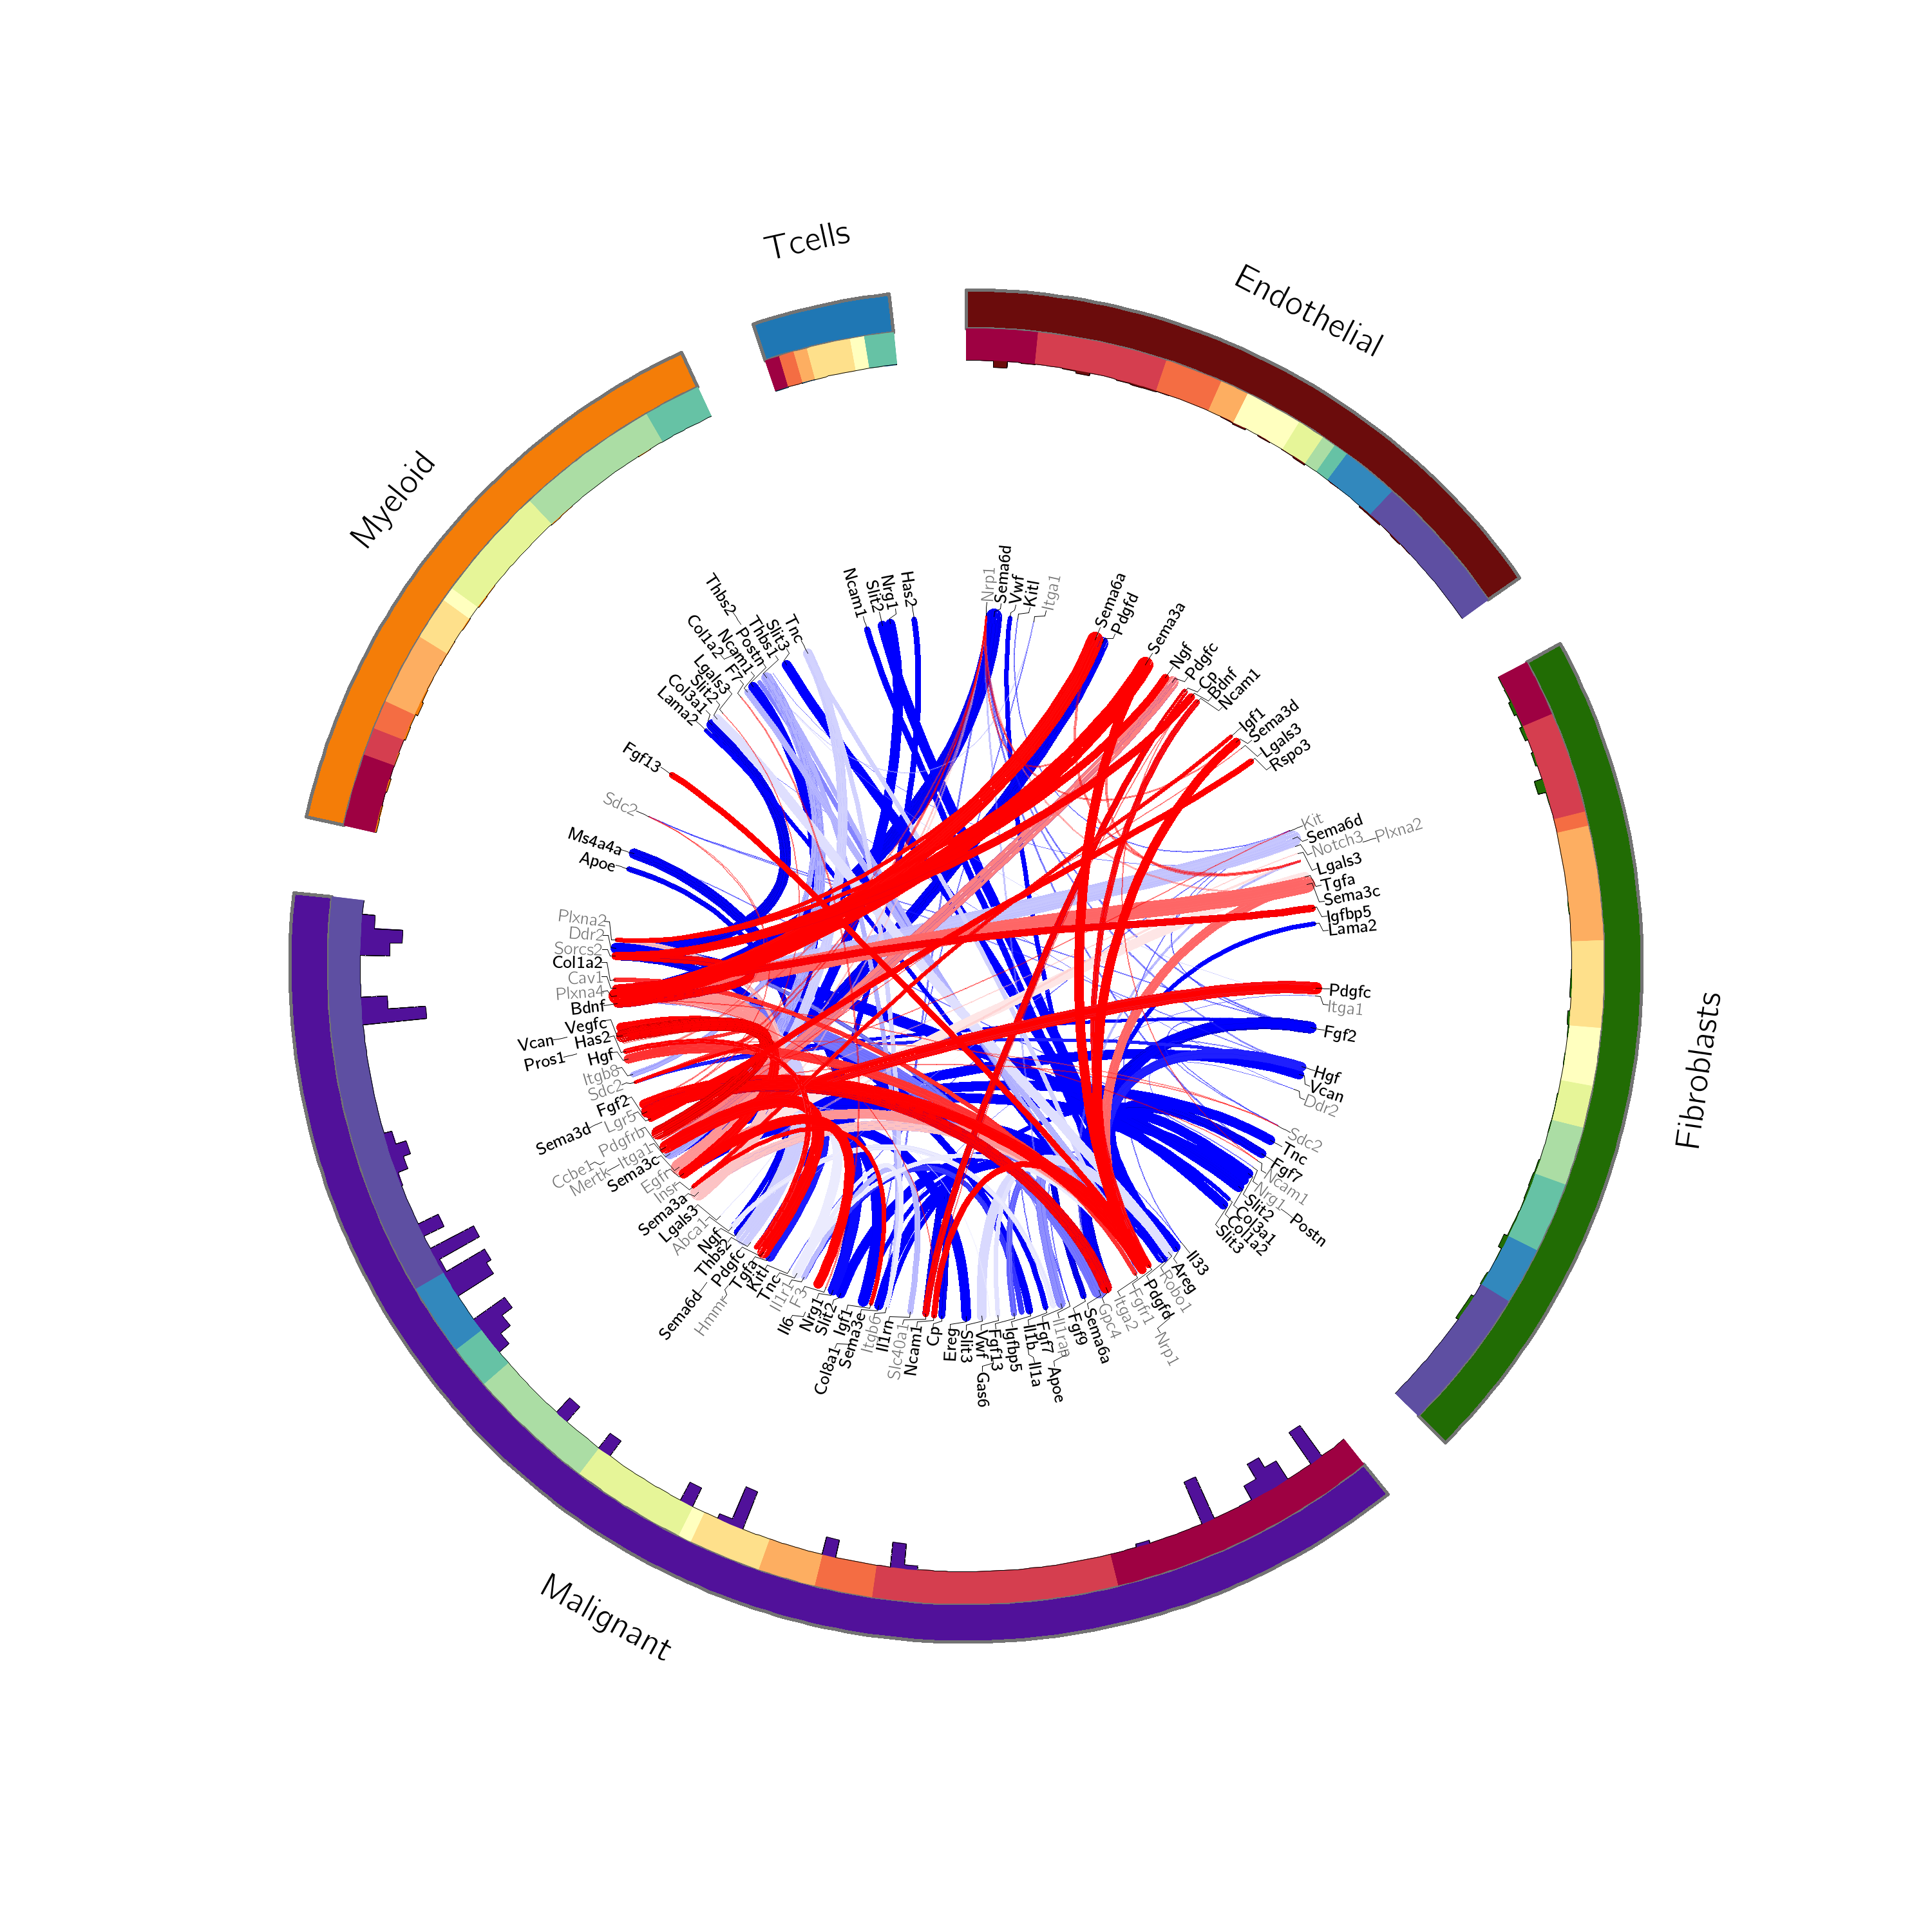

In [11]:
Image(f'{outdir}/circos.png')


In [46]:
merged_df

,Unnamed: 0,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,type,logFC_column
0,0,Endothelial,Bdnf,0.013441,0.325933,-0.055055,0.782573,142.752370,0.006076,0.0,False,True,3.549973,0.002300,ligand,1.000000
1,1,Endothelial,Cav1,0.142473,-0.251042,-0.052878,-0.602757,228.682800,0.009733,3.0,True,False,NaN,NaN,receptor,-1.000000
2,2,Endothelial,Ccbe1,0.026882,0.373745,-0.075447,0.897371,185.955930,0.007915,1.0,True,False,NaN,NaN,receptor,1.000000
3,3,Endothelial,Cd34,0.370968,-0.326943,-0.109909,-0.784998,213.478450,0.009086,1.0,True,False,-1.829768,0.001476,receptor,-1.000000
4,4,Endothelial,Col13a1,0.295699,-0.282335,-0.068469,-0.677893,209.744740,0.008927,4.0,True,False,NaN,NaN,receptor,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,Tcells,Icos,0.290393,0.400098,-0.065107,0.524096,69.574980,0.002961,1.0,True,False,NaN,NaN,receptor,1.000000
246,246,Tcells,Kit,0.054585,-0.715080,0.000341,-0.936698,92.468660,0.003936,1.0,True,False,NaN,NaN,receptor,-0.333333
247,247,Tcells,Ncam1,0.013100,-0.376598,-0.067193,-0.493314,80.096146,0.003409,0.0,False,True,-0.309866,0.044335,ligand,-1.000000
248,248,Tcells,Nrg1,0.019651,-0.153271,0.156484,-0.200773,79.850190,0.003399,0.0,False,True,-0.418306,0.017839,ligand,-1.000000


In [14]:

#This function saves the plot in the circos folder in the defined output folder
#any errors is saved to this folder as well in the circos_stdout.txt file
outdir=f'{output_dir}/circos_edited'

tmp = ct.make_circos_plot(interactions,
                          merged_df,
                          numSigI1_stat='numSigI1_fdr05',
                          links_min_numSigI1=5,
                          links_max_ligand_fdr=0.05,
                          links_min_ligand_absLog2FC=0.01,
                          #heatmap_plots=['cell_type_dc1_norm'],
                          heatmap_plots=['cell_type_dc1_norm', 'logFC_column'],
                          heatmap_cmaps={'logFC_column': 'hue240,hue000'},
                          order_col='cell_type_dc1_norm',
                          outdir=outdir,
                          colorMap=cellType_colormap,
                          cellType_labels=True)



Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 155
 num_receptor = 99
target_stats.shape = (250, 17)
No color assigned for Tcells, assigning random color
Malignant 103
Fibroblasts 56
Endothelial 42
Myeloid 40
Tcells 9
Wrote karyotype file with 5 chromosomes and 250 genes
Number of links: : 163
Wrote ../cGASKO-PD1//circos_edited/circos.conf
Done making circos plot {outdir}/circos.png
Placed 131 labels


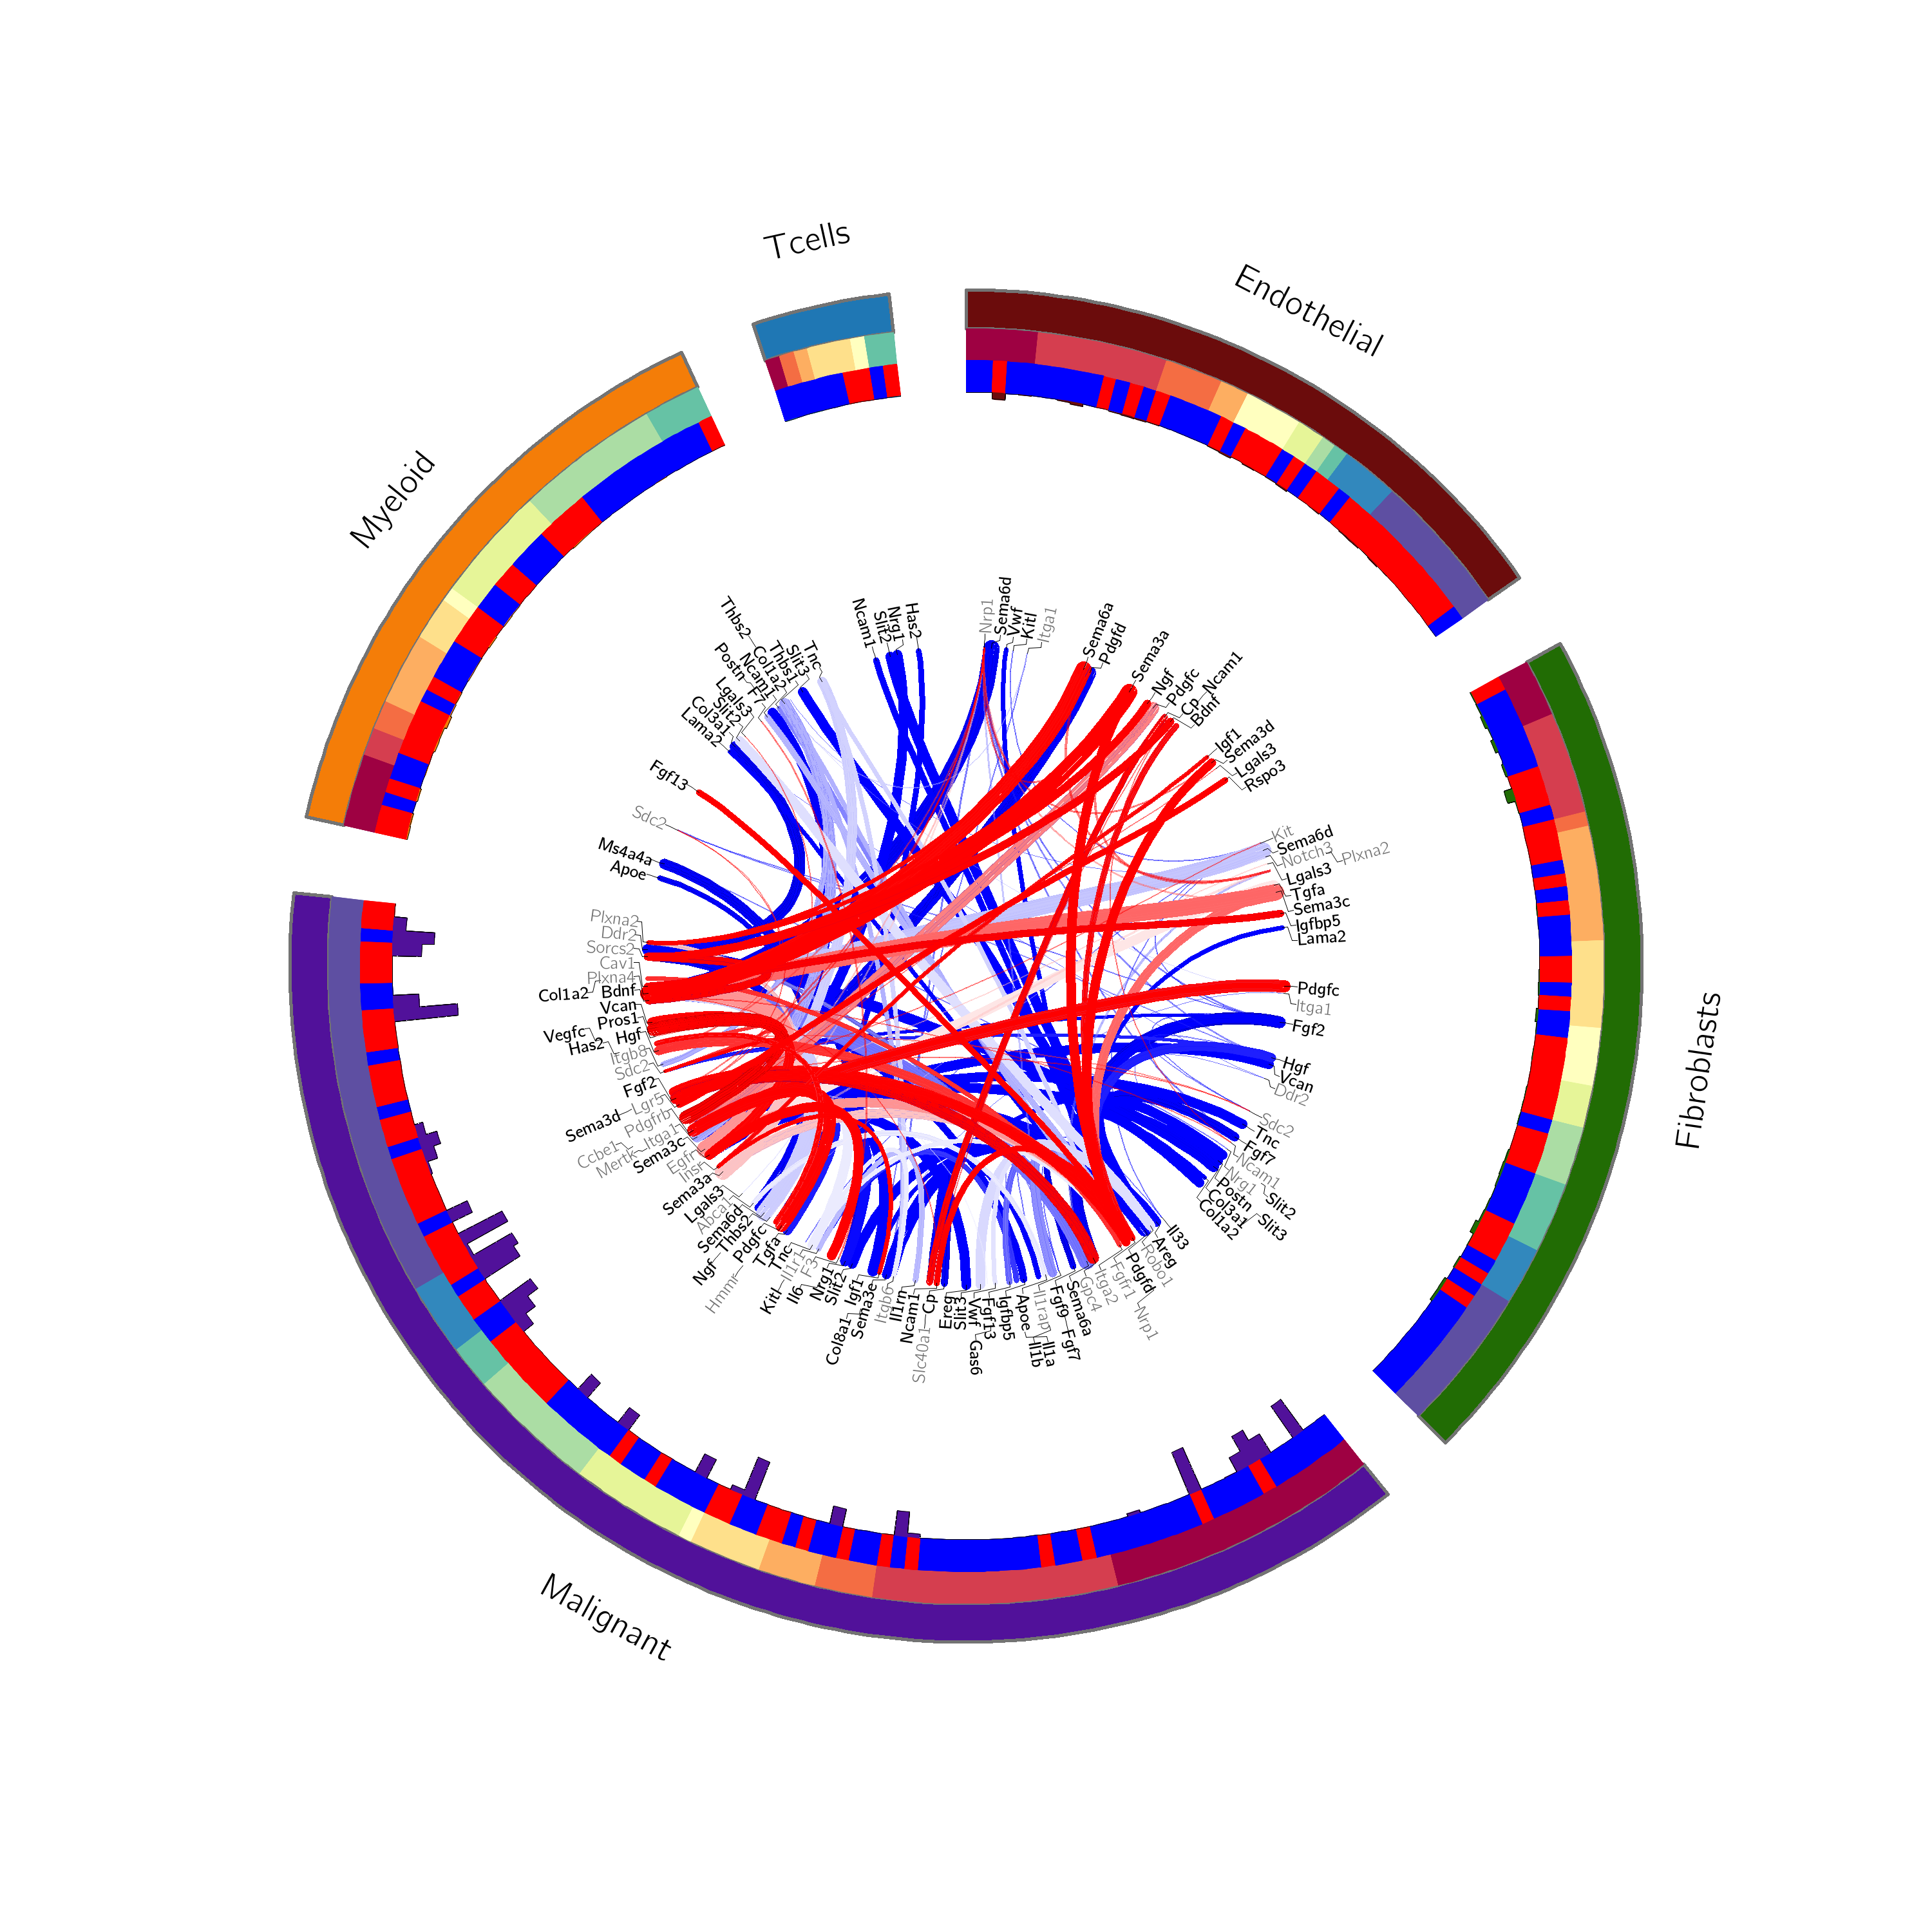

In [15]:
Image(f'{outdir}/circos.png')


In [27]:
#this cell makes the output data you request
#Make sure that the filters here align with the filters from the above function
#certain varibales are used to filter ligands (fdr for instance)
#certain variables are used to filter receptors (numSigI1_fdr05 for instance)


def target_strats_filters(row):
    if (row["receptor"]  == "True" and abs(row["numSigI1_fdr05"]) > 25):
        return True
    elif (row["receptor"]  == "True"):
        return False
    if (abs(row["fdr"]) < 0.05):
        return True
    return False

target_stats =target_stats[ target_stats.apply(lambda x: target_strats_filters(x), axis  =1)]
target_stats


new_pairs = []
for i,x in interactions.iterrows():
    ligands = target_stats[target_stats["target"] == x["ligand"]]
    receptors = target_stats[target_stats["target"] == x["receptor"]]
    for j,y in ligands.iterrows():
        for k,z in receptors.iterrows():
            new_pairs.append([ x["ligand"], x["receptor"], y["cell type"], z["cell type"], y["log2FC"], 
                            y['fdr'], y['absDE_scaled'], z['absDE_scaled'], y['numSigI1_fdr05'], z['numSigI1_fdr05'],
                              y['cell_type_dc1'], z['cell_type_dc2']
                             ])
df = pd.DataFrame(new_pairs, columns = ["ligand", "receptor", "ligand_t", "receptor_t", "log2Fc",
                                       "fdr", "ligand de", "receptor de", "ligand numSig", "receptor numSig", "dc1", "dc2"]  )


In [28]:
df.to_csv(f'{outdir}/circos_interactions.csv', index = None)

'../ContactTracingOutput/circos/circos.png'